<h1 style="text-align:center">
    Pump it up: Data Mining Water Table
</h1>

<br>

<font color="darkblue">

<h3 style="text-align:center">
    Alejandro Sierra Fernández
</h3>
    
<h3 style="text-align:center">
    02/05/2022
</h3>

<hr>


<font color="darkblue">
    
## Introducción 

En el siguiente documento se procederá a explorar y a analizar información relacionada con bombas de agua situadas en Tanzania para después hacer predicciones sobre el estado de las mismas. Los datos proceden del "Ministerio de agua" del país y los podemos encontrar a través de la competición propuesta por la página web de "Drivendata" clicando en el siguiente enlace:
    
    https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/
    
Cabe decir que no nos detendremos en algunas de las cuestiones más básicas en lo que a código se refiere, sino que iremos mostrando los resultados que vamos obteniendo y discutiendo las cuestiones relacionadas con el campo del "Machine Learning".
También informamos de que las rutas empleadas para descargar los archivos son rutas locales, que deberán cambiar dependiendo de la ubicación de los archivos en cada dispositivo. 
    
Finalmente hacemos saber que la eliminación de algunos warnings (e.g: FutureWarning) se ha hecho después de comprobar que no suponen ningún problema para el código, siendo estos de poca o ninguna importancia.
    
</font>

## Descarga y exploración de los datos:

Comenzamos descargando algunas librerías y los tres archivos que se nos ofrecen. Estos archivos contienen las variables dependientes del training-set, la variable objetivo del training-set y las variables dependientes del test-set.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot  as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  #Eliminamos los mensajes de "futurewarnings"


train = pd.read_csv("C:/Users/aleja/OneDrive/Escritorio/Machine Learning_Comp/Trainsetvalues.csv")
labels = pd.read_csv("C:/Users/aleja/OneDrive/Escritorio/Machine Learning_Comp/trainsetlabels.csv")
test = pd.read_csv("C:/Users/aleja/OneDrive/Escritorio/Machine Learning_Comp/testsetvalues.csv")




Podemos acceder a algunas de las características más generales del training set, como el nombre y tipo de las variables que lo conforman o información estadística básica sobre las variables contínuas.

In [2]:
display(train.dtypes)
display(train.describe())

id                         int64
amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_ty

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


Ya nos empieza a llamar la atención el mínimo de 0 en la variable "construction_year" y "latitud" (Tanzania se encuentra en torno a una altitud de 30º Este) o alturas de GPS negativas, aunque de estos temas nos ocuparemos algo más adelante. De momento exploramos del mismo modo la variable independiente:

In [3]:
display(labels.dtypes)
display(labels.describe())

id               int64
status_group    object
dtype: object

,id
count,59400.000000
mean,37115.131768
std,21453.128371
min,0.000000
25%,18519.750000
50%,37061.500000
75%,55656.500000
max,74247.000000


Comprobamos que el número de ID's únicos del train-set coincide con los de la variable objetivo antes de unir ambos dataframes, lo que nos facilitará la manipulación de los datos.  

In [4]:
print("Número de ID's únicos del train-set:", len(train.id.unique()))
print("Número de ID's únicos de la variable objetivo:", len(train.id.unique()))

labels = labels.drop(columns=["id"])
train = pd.concat([train, labels], axis=1)



Número de ID's únicos del train-set: 59400
Número de ID's únicos de la variable objetivo: 59400


También añadimos una columna con la variable objetivo "status_group" al dataframe del test para poder unirlo con el dataset del training. De esta manera tendremos toda la información agrupada en un único dataframe y las modificaciones que hagamos sobre la información sólo tendremos que hacerla una única vez. Además, establecemos la variable "id" como índice.

In [5]:
test["status_group"] = "unknown"
train_test = pd.concat([train, test], ignore_index=True, sort=False)
train_test.set_index(['id'], inplace=True)

Resulta siempre importante empezar explorando la variable objetivo, en nuestro caso el estado de las bombas de agua. Con el siguiente código obtenemos el porcentaje de los datos que pertenecen a cada clase y la gráfica asociada. 

functional                 54.308081
non functional             38.424242
functional needs repair     7.267677
Name: status_group, dtype: float64

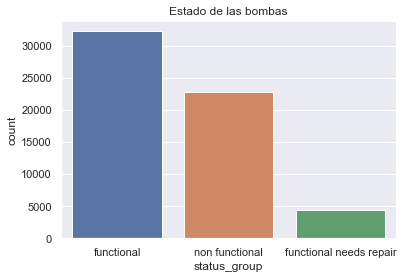

In [6]:
display(labels["status_group"].value_counts(normalize=True)*100)

sns.set_theme(style="darkgrid")
ax = sns.countplot(x="status_group", data = labels).set(title='Estado de las bombas')

Nos damos cuenta de que las clases no están balanceadas, lo que tendrá implicaciones a la hora de calibrar nuestro modelo y en la calidad de las predicciones del mismo. Resulta también interesante acceder a los histogramas de las variables dependientes:

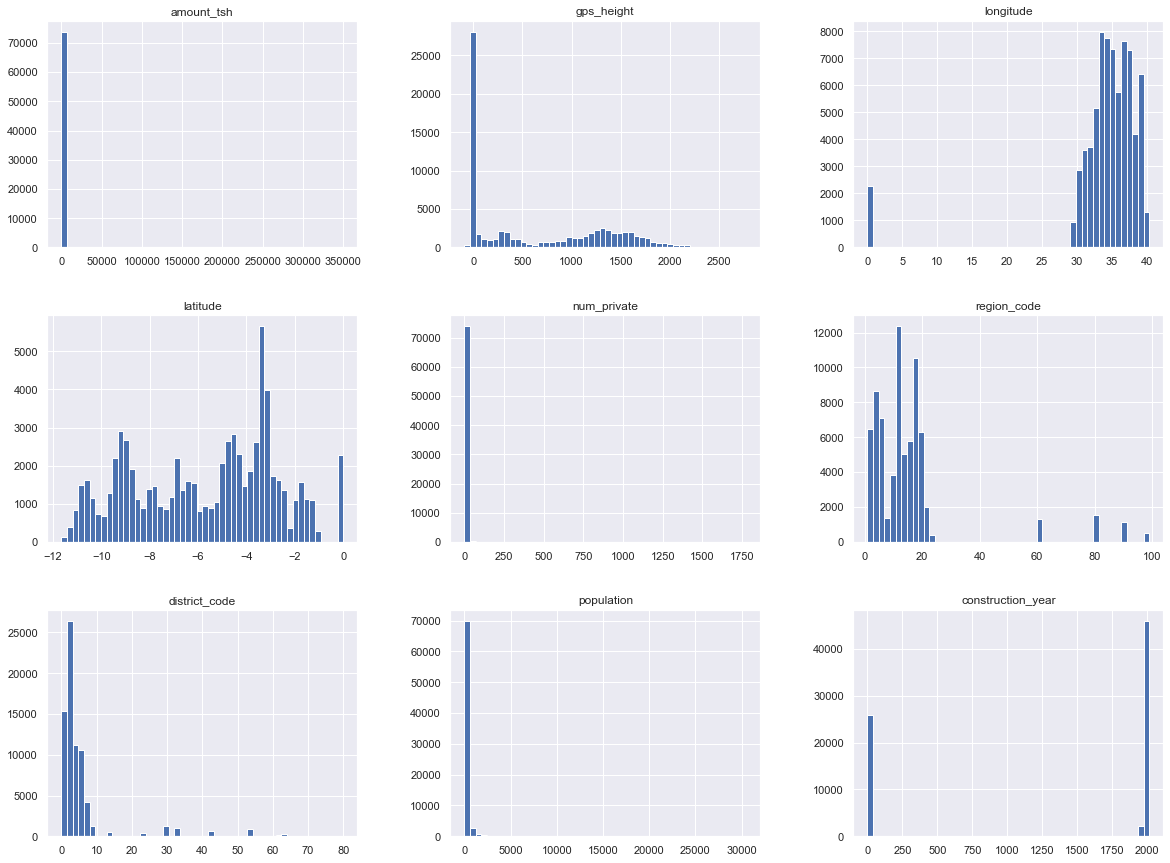

In [7]:
train_test.hist(bins=50, figsize=(20,15))
plt.show()

Nos damos cuenta de valores extraños en la latitud y la longitud (cercanos a 0), de que la variable "num_private" no aporta nada al repetirse siempre el mismo valor y de que probablemente tengamos que hacer un escalado en la mayoría de variables debido a la gran diferencia en la representación de unos valores y otros.

Podemos también acceder a los boxplots de las variables que deseemos. En este caso mostramos el reparto de la longitud para las diferentes clases de la variable objetivo. Eliminamos los outliers con el parámetro "showfliers = False" y observamos cómo las longitudes más bajas tienden a atribuirse a bombas que necesitan reparación.

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

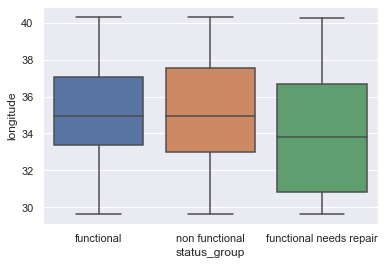

In [8]:
display(train.columns)
ax = sns.boxplot(x="status_group", y="longitude", data=train, showfliers = False)

También podemos analizar algunos gráficos de barras que pueden resultar interesantes. En los dos siguientes vemos cómo hay una clase para cada variable que se encuentra sobrerepresentada:

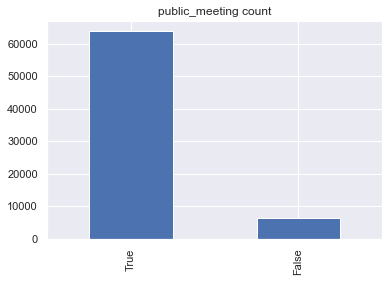

In [9]:
ax = train_test["public_meeting"].value_counts().plot.bar()
ax.set_title("public_meeting count")
plt.show()

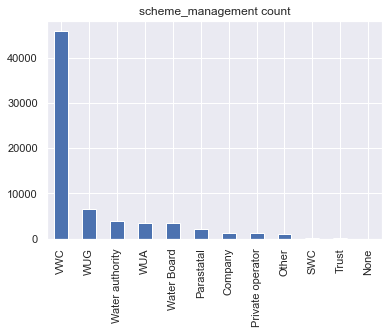

In [10]:
ax = train_test["scheme_management"].value_counts().plot.bar()
ax.set_title("scheme_management count")
plt.show()

Haciendo un scatterplot de la longitud y la latitud observamos cómo hay parte de las instancias que contienen valores nulos en estas dos variables y que no se corresponden con las coordenadas de Tanzania.

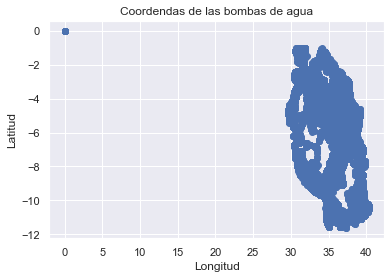

In [11]:
import matplotlib.pyplot as plt

plt.scatter(x=train['longitude'], y=train['latitude'])
plt.title("Coordendas de las bombas de agua")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

Finalmente es interesante también estudiar la correlación que existe entre las distintas variables categóricas, sobre todo aquellas que tienen un nombre similar y que nos pueden estar aportando el mismo tipo de información. Lo hacemos estudiando la tabla de contingencia asociada a las variables. Mostramos el ejemplo de dos tablas:

In [12]:
display("Cross Tabulation: water_quality vs quality_group")
display(pd.crosstab(index=train_test['water_quality'], columns=train_test['quality_group'], margins=True))
print('\n')
display("Cross Tabulation: quantity vs quantity_group")
display(pd.crosstab(index=train_test['quantity'], columns=train_test['quantity_group'], margins=True))


'Cross Tabulation: water_quality vs quality_group'

quality_group,colored,fluoride,good,milky,salty,unknown,All
water_quality,,,,,,,
coloured,623,0,0,0,0,0,623
fluoride,0,244,0,0,0,0,244
fluoride abandoned,0,23,0,0,0,0,23
milky,0,0,0,1005,0,0,1005
salty,0,0,0,0,6082,0,6082
salty abandoned,0,0,0,0,423,0,423
soft,0,0,63505,0,0,0,63505
unknown,0,0,0,0,0,2345,2345
All,623,267,63505,1005,6505,2345,74250


'Cross Tabulation: quantity vs quantity_group'

quantity_group,dry,enough,insufficient,seasonal,unknown,All
quantity,,,,,,
dry,7782,0,0,0,0,7782
enough,0,41522,0,0,0,41522
insufficient,0,0,18896,0,0,18896
seasonal,0,0,0,5075,0,5075
unknown,0,0,0,0,975,975
All,7782,41522,18896,5075,975,74250


## Preparación de los datos:

Una vez que hemos explorado los datos y que hemos entendido las características generales de las variables y las relaciones que se establecen entre algunas de ellas, pasamos a la manipulación de las mismas. Entre los objetivos se encuentran la eliminación de algunas columnas innecesarias, el modelado de las escalas y categorizaciónde las variables numéricas o el tratamiento de valores nulos o que no tienen sentido.

Empezamos con la eliminación de la variable num_private por contener casi un 99% de valores nulos.

In [13]:
display(train_test["num_private"].value_counts(normalize=True))
train_test = train_test.drop(columns=["num_private"])

0      0.987192
1      0.001266
6      0.001239
5      0.000808
8      0.000781
         ...   
136    0.000013
672    0.000013
668    0.000013
698    0.000013
420    0.000013
Name: num_private, Length: 68, dtype: float64

La variable "recorded_by" tampoco nor aporta nada al repetirse siempre el mismo valor.

In [14]:
print(train_test['recorded_by'].value_counts()) 
train_test = train_test.drop(columns=['recorded_by'])

GeoData Consultants Ltd    74250
Name: recorded_by, dtype: int64


Habíamos visto que existía una correlación entre algunas de las variables categóricas a través de tablas de contingencia, pero estudiamos este fenómeno de una forma más exhaustiva. Para ello instalamos la librería "dython", de la que emplearemos la función "theils_u". A través de esta función calcularemos se calcula el llamado coeficiente de incertidumbre, que es el que nos permite obtener un valor para la correlación de variables categóricas. 

Más adelante definimos la función "corr_categories" para recorrer nuestro dataframe y finalmente mostramos las 20 correlaciones más altas. Dejamos como referencia de esta parte del trabajo los siguientes enlaces:

https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
https://github.com/shakedzy/dython

In [296]:
!pip install dython

In [297]:
from dython.nominal import theils_u

    
def corr_categories(df):
    cols = df.columns
    df1 = pd.DataFrame(columns = ['Var1', 'Var2', 'Corr_Cat'])
    for i in cols:
        #j=i[i+1]
        for j in cols:
            if i != j:
                new_row = {'Var1':i, 'Var2':j, 'Corr_Cat': theils_u(df[i], df[j])} 
                df1 = pd.concat([df1, pd.DataFrame([new_row.values()], columns=df1.columns)], ignore_index=True)
    return df1.sort_values(by=['Corr_Cat'], ascending=False)

$\color{red}{\text{Advertencia: }}$ El siguiente bloque de código (llamada a la función cat_corr) puede tardar varios segundos en ejecutarse. El resultado final es el mismo que se muestra en la imagen siguiente:

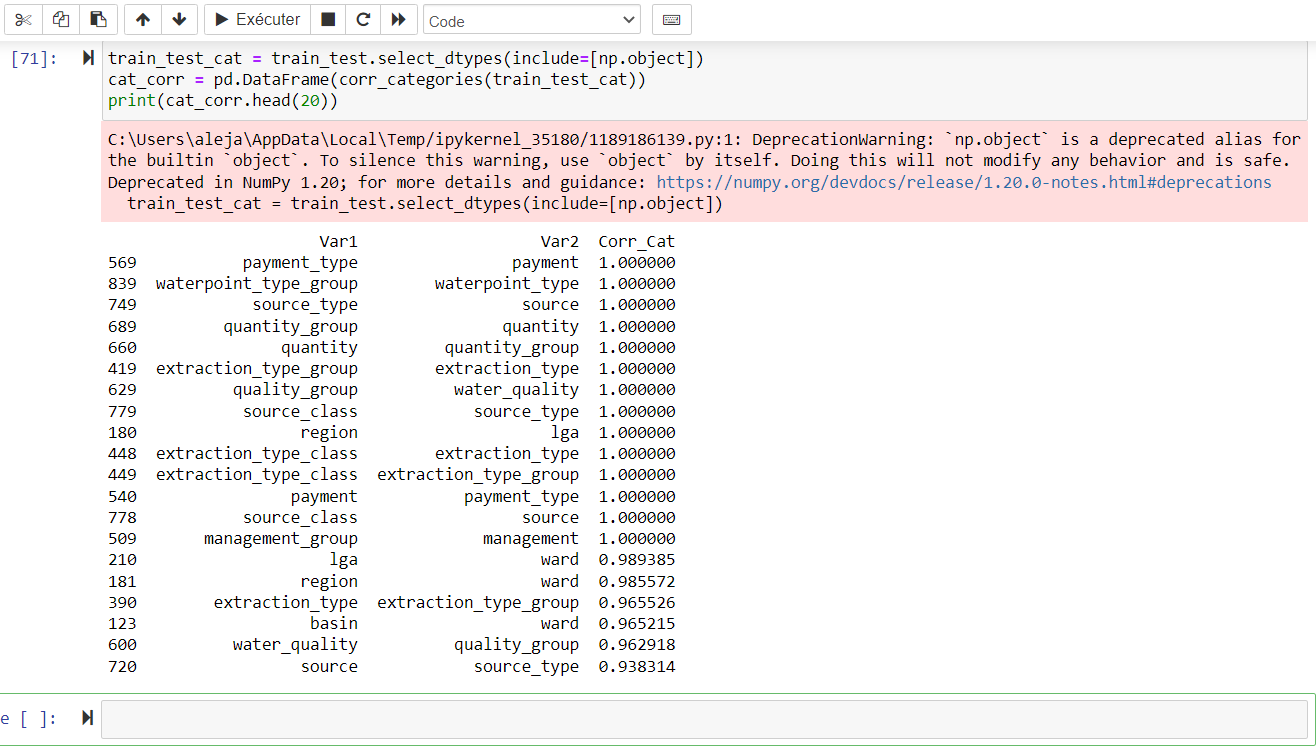

In [298]:
train_test_cat = train_test.select_dtypes(include=[np.object])  
cat_corr = pd.DataFrame(corr_categories(train_test_cat))
print(cat_corr.head(20))

En base a esta información decidimos eliminar las siguientes variables:

In [15]:
columns = columns = ['lga', 'subvillage', 'ward', 'extraction_type_group', 'extraction_type_class', 'management_group',
'payment', 'water_quality', 'quantity_group', 'source_type', 'waterpoint_type_group'] 

train_test = train_test.drop(columns, axis=1) 

Dentro de las variables continuas, nos empezamos ocupando de 'amount_tsh'. Para ello pasamos la variable a escala logarítmica intentando mejorar el histograma que habíamos obtenido anteriormente, donde los datos en torno al cero estaban sobrerepresentados.

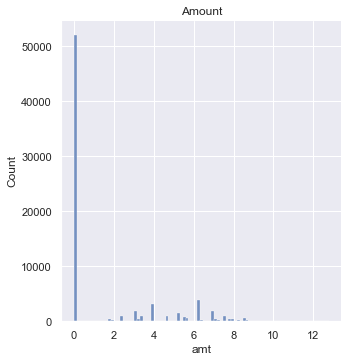

In [16]:
train_test['amt'] = np.log(train_test['amount_tsh']+1)
sns.displot(train_test['amt'])
plt.title('Amount')
plt.show()

Vemos como ganamos con respecto a la representatividad de otros valores. Hacemos lo mismo con la variable población y eliminamos las variables originales:

In [17]:
train_test["pop_log"] = train_test.population.apply(lambda x: np.log10(x+1))
train_test = train_test.drop(columns=["amount_tsh"])
train_test = train_test.drop(columns=["population"])

Cabe decir que podríamos también añadir variables que categoricen las contínuas, eligiendo por ejemplo un determinado valor que separe los datos en mayores o menores al mismo. Para la variable pop_log que acabamos de definir aplicaríamos el siguiente código:

``` python

train_test["pop_menor"] = 0
train_test.loc[(train_test["pop_log"] < 2, 'pop_menor')] = 1

```

Sin embargo, tras probar varios datasets ya depurados y distintos modelos, llegamos a la conclusión de qu estas nuevas variables categóricas no aportan una mejora con respecto a los resultados.

Con respecto a la variable "gps_height" observamos que aparecen alturas negativas, sin embargo no estamos seguros de que esta información sea errónea. Hay territorios que se encuentran por debajo del nivel del mar o quizás la bomba se encuentre bajo tierra. Ante la duda decidimos mantener la variable sin modificar.

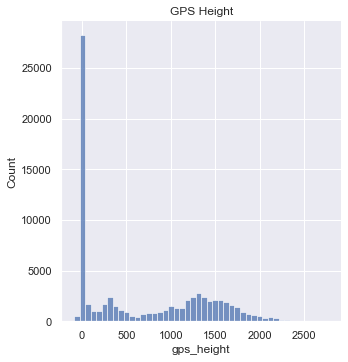

In [18]:
sns.displot(train_test['gps_height'])    
plt.title("GPS Height")
plt.show()

Comprobamos la media de valores nulos entre nuestras variables y observamos que "scheme_name" tiene cerca de un 48% de estos valores. Decidimos que es poco representativa y la eliminamos:

In [19]:
print(train_test.isnull().mean())
train_test = train_test.drop(columns=["scheme_name"])

date_recorded        0.000000
funder               0.060660
gps_height           0.000000
installer            0.061037
longitude            0.000000
latitude             0.000000
wpt_name             0.000000
basin                0.000000
region               0.000000
region_code          0.000000
district_code        0.000000
public_meeting       0.055960
scheme_management    0.065266
scheme_name          0.474855
permit               0.051084
construction_year    0.000000
extraction_type      0.000000
management           0.000000
payment_type         0.000000
quality_group        0.000000
quantity             0.000000
source               0.000000
source_class         0.000000
waterpoint_type      0.000000
status_group         0.000000
amt                  0.000000
pop_log              0.000000
dtype: float64


A continuación nos ocupamos de la variable "Funder", que vemos que tiene tanto NA's como 0's. Los agrupamos en una sola categoría a la que llamamos "unknown". Después mostramos cuántas instancias pertenecen a cada categoría:

In [20]:
train_test['funder'] = train_test['funder'].fillna(value="unknown")
train_test["funder"] = train_test['funder'].replace(to_replace = '0', value ='unknown')
print(train_test['funder'].value_counts())
print('\n')
print(train_test['funder'].value_counts().head(30))            


Government Of Tanzania    11299
unknown                    5484
Danida                     3907
Hesawa                     2782
Rwssp                      1703
                          ...  
Sido                          1
Mosqure                       1
Kkkt Canal                    1
Rc Missionary                 1
Velem                         1
Name: funder, Length: 2140, dtype: int64


Government Of Tanzania    11299
unknown                    5484
Danida                     3907
Hesawa                     2782
Rwssp                      1703
World Bank                 1701
Kkkt                       1623
World Vision               1562
Unicef                     1324
Tasaf                      1136
Dhv                        1065
District Council           1037
Private Individual         1034
Dwsp                       1012
Norad                       949
Germany Republi             765
Water                       739
Tcrs                        735
Ministry Of Water           7

Decidimos quedarnos con las 30 categorías más representadas y las demás las agrupamos en una nueva a la que llamamos "Others"

In [21]:
names = train_test['funder'].value_counts().head(20).index.tolist()                     
train_test['new_funder'] = train_test['funder']
train_test.loc[~train_test["new_funder"].isin(names), "new_funder"] = "Others"
train_test = train_test.drop(columns=["funder"])

A continuación sustituímos los NA's de tres variables por sus modas:

In [22]:
train_test['scheme_management']=train_test['scheme_management'].fillna(train_test['scheme_management'].mode()[0]) 
train_test['public_meeting']=train_test['public_meeting'].fillna(train_test['public_meeting'].mode()[0]) 
train_test['permit']=train_test['permit'].fillna(train_test['permit'].mode()[0]) 

Nos ocupamos también de la variable "installer", donde nos damos cuenta de que hay muchas categorías diferentes que deberían ser la misma (Discrepancia el puntos, mayúsculas y minúsculas, etc...). Renombramos estas categorías para unificar ciertas instancias bajo una misma. Finalmente nos quedamos con las más representadas y las demás la unimos en una nueva categoría a la que llamamos "Others"

In [23]:
train_test['installer']=train_test['installer'].fillna(value="unknown") #OK
train_test['installer'] = train_test['installer'].replace(to_replace = '0', value ='unknown')
train_test['installer'].replace(to_replace = ('District Water Department', 'District water depar','Distric Water Department'), value ='District water department')
train_test['installer'].replace(to_replace = ('FinW','Fini water','FINI WATER'), value ='Fini Water')
train_test['installer'].replace(to_replace = 'JAICA', value ='Jaica')
train_test['installer'].replace(to_replace = ('COUN', 'District COUNCIL', 'DISTRICT COUNCIL','District Counci','District Council','Council','Counc','District  Council','Distri'), value ='District council')
train_test['installer'].replace(to_replace = ('RC CHURCH', 'RC Churc', 'RC','RC Ch','RC C','RC CH','RC church','RC CATHORIC',) ,value ='RC Church')
train_test['installer'].replace(to_replace = ('Central Government','Tanzania Government', 'central government',
'Cental Government', 'Cebtral Government', 'Tanzanian Government','Tanzania government', 'Centra Government',
'CENTRAL GOVERNMENT', 'TANZANIAN GOVERNMENT','Central govt', 'Centr', 'Centra govt') , value ='Central government')

train_test['installer'].replace(to_replace = ('World vision', 'World Division','World Vision'),value ='world vision')
train_test['installer'].replace(to_replace = ('Unisef','UNICEF'),value ='Unicef')
train_test['installer'].replace(to_replace = 'DANID', value ='DANIDA')
train_test['installer'].replace(to_replace = ('villigers', 'villager', 'Villagers', 'Villa', 'Village', 'Villi', 'Village Council','Village Counil', 'Villages', 'Vill', 'Village community','Villaers',
'Vdatafullommunity', 'Villag','Villege Council', 'Village council','Village  Council','Villagerd','Villager', 'Village Technician', 'Village Office','Village community members'), value ='villagers')

train_test['installer'].replace(to_replace =('Commu','Communit','commu','COMMU', 'COMMUNITY'), value ='Community')
train_test['installer'].replace(to_replace = ('GOVERNMENT', 'GOVER', 'GOVERNME', 'GOVERM','GOVERN','Gover','Gove', 
'Governme','Governmen') ,value ='Government')

train_test['installer'].replace(to_replace = 'Hesawa', value ='HESAWA')
train_test['installer'].replace(to_replace = ('Colonial Government'), value ='Colonial government')
train_test['installer'].replace(to_replace = ('Government of Misri'), value ='Misri Government')
train_test['installer'].replace(to_replace = ('Italy government'), value ='Italian government')
train_test['installer'].replace(to_replace = ('British colonial government'), value ='British government')
train_test['installer'].replace(to_replace = ('Concern /government'), value ='Concern/Government')
train_test['installer'].replace(to_replace = ('Village Government'), value ='Village government')
train_test['installer'].replace(to_replace = ('Government and Community'), value ='Government /Community')
train_test['installer'].replace(to_replace = ('Cetral government /RC'), value ='RC church/Central Gover')

names = train_test['installer'].value_counts().head(10).index.tolist()
train_test['new_installer'] = train_test['installer']
train_test.loc[~train_test["new_installer"].isin(names), "new_installer"] = "Others"
train_test = train_test.drop(columns=["installer"])

Borramos la variable "region" (categórica) puesto que ya tenemos "region_code" (numérica).

In [24]:
train_test = train_test.drop(columns=['region'])

Separamos el día, la semana y el año de la variable que contiene la fecha en la que se tomaron los datos para cada instancia.

In [25]:
train_test['date'] = pd.to_datetime(train_test['date_recorded'], format='%Y-%m-%d %H:%M:%S')
train_test = train_test.drop(columns=['date_recorded'])
train_test['year'] = pd.DatetimeIndex(train_test['date']).year
train_test['month'] = pd.DatetimeIndex(train_test['date']).month
train_test['week'] = train_test['date'].dt.isocalendar().week
train_test = train_test.drop(columns=['date'])        


Incluímos ahora algunas variables nuevas:

In [26]:
train_test["date_recorded_months"] = train_test["year"] - train_test["construction_year"]
train_test.loc[train_test["date_recorded_months"] == train_test['year'], "date_recorded_months"] = 0
train_test['date_recorded_months'] = train_test['date_recorded_months'].replace(0, round(train_test['date_recorded_months'].mean()))  

train_test["water/year"] = train_test["amt"] / train_test["date_recorded_months"]        
train_test['water/year'] = train_test['water/year'].replace([np.inf, -np.inf], np.nan)
train_test['water/year'] = train_test['water/year'].replace(np.nan, 0)   

train_test["pop/year"] = train_test["pop_log"] / train_test["date_recorded_months"]
train_test['pop/year'] = train_test['pop/year'].replace([np.inf, -np.inf], np.nan)
train_test['pop/year'] = train_test['pop/year'].replace(np.nan, 0)                   

train_test["water/person"] = train_test["amt"] / train_test["pop_log"]               
train_test['water/person'] = train_test['water/person'].replace([np.inf, -np.inf], np.nan)
train_test['water/person'] = train_test['water/person'].replace(np.nan, 0)

train_test['is_construct'] = train_test['construction_year'] != 0

In [27]:
print(train_test['date_recorded_months'])

id
69572    12
8776      3
34310     4
67743    27
19728    10
         ..
39307    23
18990    17
28749     3
33492     4
68707     5
Name: date_recorded_months, Length: 74250, dtype: int64


Nos ocupamos ahora de la latitud y de la longitud. Lo que haremos será aislar las instancias que no tengan sentido (son siempre ambos valores simultáneamente los que se aparecen como 0's y en ningún caso encontramos una de las dos variables que sea outlier y la otra no) y les aplicaremos la media de las coordenadas de la región a la que pertenecen, teniendo únicamente en consideración los valores no nulos. 

In [28]:
pd.options.mode.chained_assignment = None 

a= train_test[train_test["longitude"] < 1]
a.iloc[:,train_test.columns == "latitude"]= np.nan
a.iloc[:,train_test.columns == "longitude"]= np.nan
train_test[train_test["longitude"] < 1] = a
grouped = train_test.groupby("region_code")
train_test["longitude"] = train_test.groupby("region_code").transform(lambda x: x.fillna(x.mean())).longitude
train_test["latitude"] = train_test.groupby("region_code").transform(lambda x: x.fillna(x.mean())).latitude

A continuación, escalamos las variables numéricas y codificamos las categóricas. Cabe decir que hemos probado con el "One-Hot-Encoding" pero nos da peores resultados, por lo que nos quedamos con el "Label-Encoding":

In [29]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

a=(train_test.select_dtypes(include=np.number).columns.tolist())

warnings.simplefilter(action='ignore', category=DeprecationWarning)

b=(train_test.select_dtypes(include=[np.object, bool]).columns.tolist())
print("Variables Numéricas")
print(a)
print('\n')
print("Variables Categóricas")
print(b)

prueba_escalado = sc.fit_transform(train_test[a])

train_test = train_test.drop(columns=a) 
train_test[a] = prueba_escalado

Variables Numéricas
['gps_height', 'longitude', 'latitude', 'region_code', 'district_code', 'construction_year', 'amt', 'pop_log', 'year', 'month', 'week', 'date_recorded_months', 'water/year', 'pop/year', 'water/person']


Variables Categóricas
['wpt_name', 'basin', 'public_meeting', 'scheme_management', 'permit', 'extraction_type', 'management', 'payment_type', 'quality_group', 'quantity', 'source', 'source_class', 'waterpoint_type', 'status_group', 'new_funder', 'new_installer', 'is_construct']


Mapeamos la variable "status_group" para convertirla en numérica y la renombramos como "target". Además, separamos los datos del train del test precisamente sirviéndonos de esta variable, puesto que a los datos del test le habíamos adjuntado la columna con el valor "unknown".

In [30]:
dis_stat_grp = {'functional': 0, 'non functional': 1, 'functional needs repair': 2, 'unknown': -1} 
train_test['target'] = train_test['status_group'].map(dis_stat_grp)  
del train_test['status_group']

train = train_test.loc[(train_test['target'] != -1)]
test = train_test.loc[(train_test['target'] == -1)]
del test['target']

Codificamos las categorías importando la librería "category_encoders".

In [31]:
import category_encoders as ce
encoder = ce.OrdinalEncoder()
train = encoder.fit_transform(train)
test = encoder.fit_transform(test)

Finalmente hacemos una última comprobación para ver si tenemos algúna variable con valores missings.

In [32]:
print("Columnas con valores NA:")
print(train.isna().any())

Columnas con valores NA:
wpt_name                False
basin                   False
public_meeting          False
scheme_management       False
permit                  False
extraction_type         False
management              False
payment_type            False
quality_group           False
quantity                False
source                  False
source_class            False
waterpoint_type         False
new_funder              False
new_installer           False
is_construct            False
gps_height              False
longitude               False
latitude                False
region_code             False
district_code           False
construction_year       False
amt                     False
pop_log                 False
year                    False
month                   False
week                    False
date_recorded_months    False
water/year              False
pop/year                False
water/person            False
target                  False
dtype: bool


## Construcción del modelo:

Una vez que hemos estudiado nuestras variables, entendido el problema y las relaciones que existen entre ellas y preparado los datos, pasamos elegir qué modelo es el que nos ofrece una mayor calidad en nuestras predicciones y cuáles son los parámetros que ajustan mejor los datos. Para ello emplearemos una serie de técnicas que veremos a continuación: 

Empezamos importando "sklearn" y los modelos y funciones que vamos a emplear:

In [33]:
import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier

classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),       
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    ExtraTreesClassifier()
]

A continuación separamos la variable objetivo del dataframe y empleamos "train_test_split" para separar el 90% de los datos para entrenar a los modelos y el 10% para el set de validación. Este porcentaje lo elegimos el parámetro "test_size". La división de los datos la generamos dentro de una función a la que llamamos "model_and_test" y que nos permitirá ir entrenando a los distintos modelos y printeando  la precisión que van teniendo:

In [34]:
X = train.loc[:, train.columns != 'target']
y = train.loc[:, train.columns == 'target']

def model_and_test(X, y, classifiers):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state = 35)
    y_train = np.ravel(y_train)
    for model in classifiers:
        this_model = model.__class__.__name__
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        print(f'{this_model} accuracy:')
        score = accuracy_score(y_val, y_pred)
        print(f'{score:.4f}')
        print('\n')

In [432]:
model_and_test(X, y, classifiers)

KNeighborsClassifier accuracy:
0.5547


DecisionTreeClassifier accuracy:
0.7419


RandomForestClassifier accuracy:
0.8056


AdaBoostClassifier accuracy:
0.7226


GradientBoostingClassifier accuracy:
0.7503


ExtraTreesClassifier accuracy:
0.7949




Decidimos quedarnos con el RandomForestClassifier como modelo por tener el accuracy más elevado, aunque el ExtraTreesClassifier no muestra un rendimiento muy diferente. A continuación empleamos el RandomizedSearchCV para estudiar qué combinación de parámetros funciona mejor. Además, el método también emplea cross-validation para entrenar y testears las distintas combinaciones de parámetros. De este modo:

$\color{red}{\text{Advertencia: }}$ El siguiente bloque de código puede tardar unos segundos en ejecutarse: En un bloque posterior definimos directamente el modelo con los mejores parámetros (max_depth=20 y n_estimators=300)

In [433]:
from sklearn.model_selection import RandomizedSearchCV

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state = 35)

param_distributions = {
    'n_estimators': [300,400,500], 
    'max_depth': [20,30,40]
}


model = RandomForestClassifier(n_jobs=-1, random_state=42)


search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    scoring='accuracy',
    n_iter=9,
    n_jobs=-1,
    cv=5,
    verbose=10,
    return_train_score=True,
    random_state=42
)

y_train = np.ravel(y_train)
search.fit(X_train, y_train)

print('Training Accuracy Score:', search.best_score_)  
best = search.best_estimator_
print(best)                                            
y_pred = best.predict(X_val)
print('Validation Set Accuracy Score:', accuracy_score(y_val, y_pred))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Training Accuracy Score: 0.8089038533482977
RandomForestClassifier(max_depth=20, n_estimators=300, n_jobs=-1,
                       random_state=42)
Validation Set Accuracy Score: 0.8062289562289562


In [38]:
#Volvemos a generar el modelo y a entrenarlo para no vernos obligados correr el código anterior. 

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state = 35)
y_train = np.ravel(y_train)
best = RandomForestClassifier(n_jobs=-1, max_depth=20, n_estimators=300, random_state=42)
best.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_estimators=300, n_jobs=-1,
                       random_state=42)

Obtenemos algo más del 80% de precisión tanto en el set de training como en el de validación. El hecho de que la precisión del trainig no sea muy superior nos indica que no existe demasiado overfitting, lo que es una buena señal. Además, el resultado obtenido es considerablemente bueno teniendo en cuenta el potencial que tienen nuestros datos. Podemos hacer un plot de las variables más importantes, a partir del cual podríamos comenzar a jugar eliminando algunas y añadiendo otras, viendo cómo afecta esto a la precisión del modelo.

In [39]:
important_features = pd.DataFrame(best.feature_importances_, index = X_train.columns,
columns = ['importance']).sort_values('importance', ascending=False)
print(important_features.iloc[1:50, :])

                      importance
longitude               0.094342
latitude                0.091989
waterpoint_type         0.057019
wpt_name                0.056943
extraction_type         0.055498
gps_height              0.050509
pop/year                0.041876
date_recorded_months    0.036869
week                    0.035869
construction_year       0.031068
pop_log                 0.030469
source                  0.026539
new_funder              0.026466
district_code           0.024305
water/year              0.023809
water/person            0.022358
payment_type            0.020726
region_code             0.019513
amt                     0.019099
month                   0.017003
new_installer           0.016828
basin                   0.016576
management              0.016319
scheme_management       0.013840
quality_group           0.011552
source_class            0.008934
permit                  0.007566
year                    0.006117
public_meeting          0.006010
is_constru

Finalmente predecimos sobre los datos del test y volvemos a modificar los datos para guardarlos en el formato que se nos pide en la página web de la competición.

In [42]:
y_pred_def = best.predict(test)
print("Array con las predicciones obtenidas:")
print(y_pred_def)
print(type(y_pred_def))
print("\n")
test.reset_index(inplace=True)
indices = test['id']
test.set_index(['id'], inplace=True)

df_final = pd.DataFrame(y_pred_def, columns = ['status_group'])
df_final = df_final.join(indices)
df_final = df_final[['id', 'status_group']]

print("Primeros cinco elementos antes de mapear:")
print(df_final.head(5))
print("\n")

print("Conteo de las predicciones antes de mapear:")
print(df_final.loc[:, 'status_group'].value_counts())
print("\n")

relacion = {0: 'functional', 1: 'non functional', 2: 'functional needs repair'} 
df_final['status_group'] = df_final['status_group'].map(relacion)  

print("Conteo de las predicciones después de mapear:")
print(df_final.loc[:, 'status_group'].value_counts())
print("\n")
print("Primeros cinco elementos después de mapear:")
print(df_final.head(5))

#df_final.to_csv("ruta/resultados.csv", index=False)

Array con las predicciones obtenidas:
[0 0 0 ... 0 0 1]
<class 'numpy.ndarray'>


Primeros cinco elementos antes de mapear:
      id  status_group
0  50785             0
1  51630             0
2  17168             0
3  45559             1
4  49871             0


Conteo de las predicciones antes de mapear:
0    9155
1    5196
2     499
Name: status_group, dtype: int64


Conteo de las predicciones después de mapear:
functional                 9155
non functional             5196
functional needs repair     499
Name: status_group, dtype: int64


Primeros cinco elementos después de mapear:
      id    status_group
0  50785      functional
1  51630      functional
2  17168      functional
3  45559  non functional
4  49871      functional


Tras algunas modificaciones menores en los parámetros del modelo y en el tratado de los datos obtenemos una precisión de 0.8166, que es una cifra bastante buena si tenemos en consideración que no hemos aplicado los métodos más complejos ni en la limpieza y modificación de los datos ni en la configuración de nuestro modelo final. Siguiendo una metodología intuitíva y fácil de entender se consiguen, para los datos que se nos ofrecen, resultados de buena calidad.

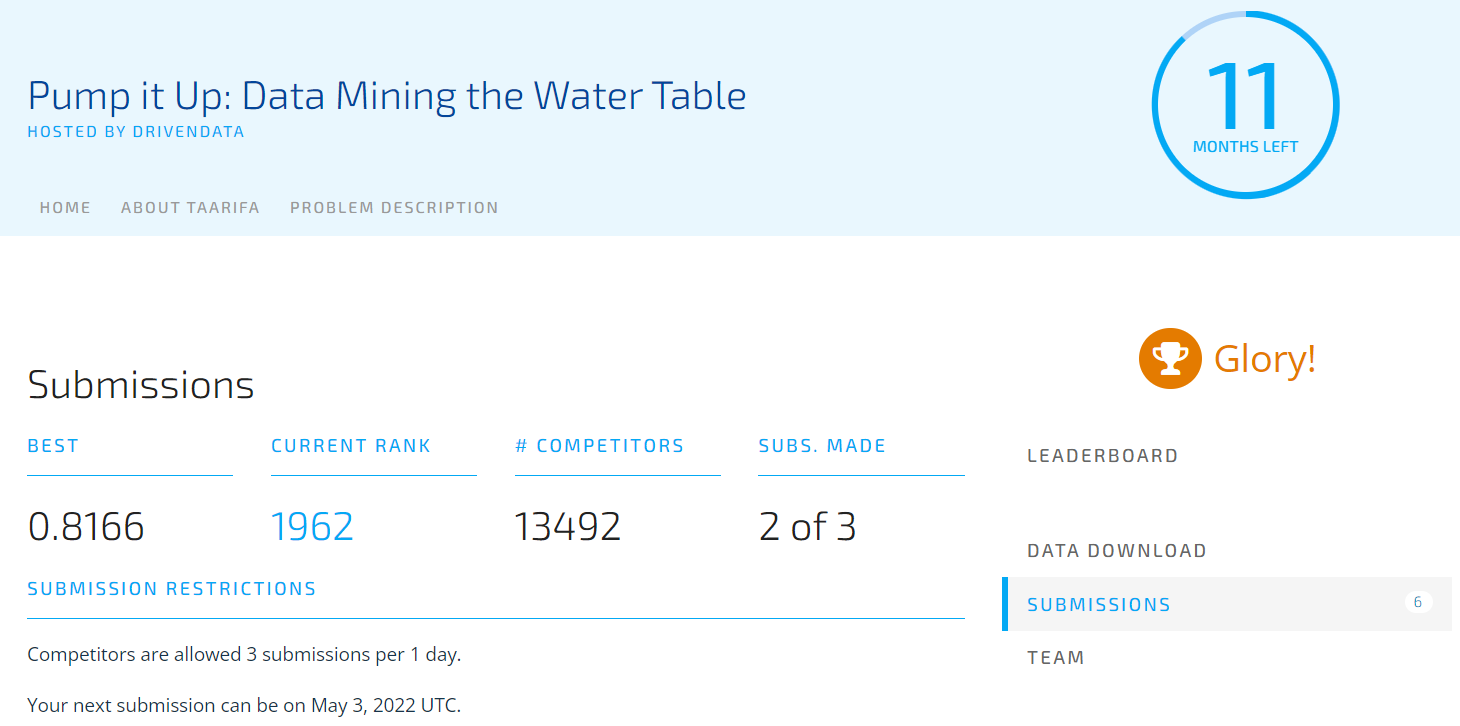